# ***Titanic Kaggle Project*** - 6/3/2019

*This is my first project in Python. I am transitioning from using R through R studio. This project is a jump into the pool of sorts, a "learning as I go" experience to understand how to use Python effectively for data science.*

## ***Initial Data Handling***

### Import the necessary packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Import the data

In [2]:
training = pd.read_csv("train.csv")

### Explore the data

In [3]:
type(training)
training.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [4]:
training.shape
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## ***Examining Variables***

*We will examine each variable in depth to account for missing data, and fully understand how each variable affects the chances of survival.*

### 'Survived'

First, while trivial, we will understand the 'Survived' variable. 

In [5]:
print(training['Survived'].head(6))
print(training['Survived'].unique())
print(training['Survived'].isnull().sum())

0    0
1    1
2    1
3    1
4    0
5    0
Name: Survived, dtype: int64
[0 1]
0


We find that the 'Survived' variable is most straightforward, a boolean value of 0 = dead and 1 = alive. There are no missing values. 

### 'Pclass'

Next, we will understand the 'Pclass' variable. 

In [6]:
print (training['Pclass'].head(6))
print(training['Pclass'].unique())
print(training['Pclass'].isnull().sum())

0    3
1    1
2    3
3    1
4    3
5    3
Name: Pclass, dtype: int64
[3 1 2]
0


We can see that the 'Pclass' variable is categorical variable, denoting either 1st, 2nd, 3rd class for each passenger.

### 'Name'

Next, we will understand the 'Name' variable. 


In [7]:
print (training['Name'].head(6))
print(training['Name'].isnull().sum())

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
Name: Name, dtype: object
0


Observing this variable, we can see several important things: Last Name and Titles. We can extract the last name to count family sizes, while we can count family sizes uses the last name. A possible point of concern is the instance of the same last name, but we could probably verify relationships using cabin location, class, and ticket number.  

Extraction of last name and title. Then we will add it to the original dataframe. 

In [8]:
extract_names = training['Name']
parts = extract_names.str.split(".", n = 1, expand = True)
parts = parts.iloc[:,0]
parts = parts.str.split(",", n = 1, expand = True)
parts.columns = ["Last", "Title"]
print(parts.iloc[0:6,:])
training1 = pd.concat([training, parts], axis=1)
training1 = training1.drop(columns="Name")
training1['Last'] = training1['Last'].str.strip()
training1['Title'] = training1['Title'].str.strip()

        Last  Title
0     Braund     Mr
1    Cumings    Mrs
2  Heikkinen   Miss
3   Futrelle    Mrs
4      Allen     Mr
5      Moran     Mr


In [9]:
print(training1.head(2))

   PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch     Ticket  \
0            1         0       3    male  22.0      1      0  A/5 21171   
1            2         1       1  female  38.0      1      0   PC 17599   

      Fare Cabin Embarked     Last Title  
0   7.2500   NaN        S   Braund    Mr  
1  71.2833   C85        C  Cumings   Mrs  


Since it is less confusing, we can first attempt to make meaning of the title variable. Specifically, we can understand whether all were correctly spliced, the unique values, and the frequency of each.

In [10]:
print(training1['Title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']


Firstly, we can see that there are some repeats. Ms, Mme, and Mlle all seem to mean Miss. We can replace every single instance of these three with Miss. Further, there seem to be no benefit to having many different upper class categories. We can bucket all these as "VIP"

In [11]:
training1['Title'] = training1['Title'].replace(["Mme", "Ms", "Mlle"], "Miss")
training1['Title'] = training1['Title'].replace(["Don", "Rev", "Dr", "Major", "Lady", "Sir", "Col", "Capt", "the Countess", "Jonkheer"], "VIP")
print(training1['Title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'VIP']


In [12]:
title_counts = (training1['Title']).value_counts().to_dict()
print(type(title_counts))
print(title_counts)

<class 'dict'>
{'Mr': 517, 'Miss': 186, 'Mrs': 125, 'Master': 40, 'VIP': 23}


We can see that the title is very useful. It can provide gender, occupation, location on ship, and social class. 

Now, we will examine the newly created "Last" class. We can first build a dictionary that counts the frequency of last name, then add another column called "Last_freq" to show family size. We will also need to account for those with the same last name. 

In [13]:
last_dic = (training1['Last']).value_counts().to_dict()
last_freq = training1['Last']
last_freq1 = last_freq.map(last_dic)
last_freq1 = last_freq1.to_frame()
last_freq1.columns = ['LastFreq']
print(last_freq1.head(6))

   LastFreq
0         2
1         1
2         1
3         2
4         2
5         3


We have successfully created a dictionary, and remapped it to a new column last_freq1, which we will add to the main dataframe. First, lets examine this column and make sure it is correct. 

In [14]:
print(last_freq1.isnull().sum())
print(last_freq1.describe())

LastFreq    0
dtype: int64
         LastFreq
count  891.000000
mean     1.882155
std      1.488014
min      1.000000
25%      1.000000
50%      1.000000
75%      2.000000
max      9.000000


None of these values seem too unreasonable, so we will continue on, after first appending this column to the training dataframe. 

In [15]:
training2 = pd.concat([training1, last_freq1], axis=1)
print(training2.columns)
print(training2.head(6))

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Last', 'Title', 'LastFreq'],
      dtype='object')
   PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch  \
0            1         0       3    male  22.0      1      0   
1            2         1       1  female  38.0      1      0   
2            3         1       3  female  26.0      0      0   
3            4         1       1  female  35.0      1      0   
4            5         0       3    male  35.0      0      0   
5            6         0       3    male   NaN      0      0   

             Ticket     Fare Cabin Embarked       Last Title  LastFreq  
0         A/5 21171   7.2500   NaN        S     Braund    Mr         2  
1          PC 17599  71.2833   C85        C    Cumings   Mrs         1  
2  STON/O2. 3101282   7.9250   NaN        S  Heikkinen  Miss         1  
3            113803  53.1000  C123        S   Futrelle   Mrs         2  
4           

### 'Sex'

On to the 'Sex' variable. 

In [16]:
print (training2['Sex'].head(6))
print(training2['Sex'].isnull().sum())

0      male
1    female
2    female
3    female
4      male
5      male
Name: Sex, dtype: object
0


We can see that the 'Sex' variable is rather straightforward. It is a binary variable, yielding either Male or Female, and has zero missing values. 

### 'Age'

Observe the Age variable. 

In [17]:
print (training2['Age'].head(6))
print(training2['Age'].isnull().sum())
training2['Age'].describe()

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
5     NaN
Name: Age, dtype: float64
177


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

This is our first variable where we have missing values - 177 to be exact. Otherwise, this is an integer variable, obviously yielding the age of the passenger. Since age is related to both the number of parents/children, and the number of siblings/spouse and we are hindered by a rather small training datset, we could possible try to estimate the age of these missing values. First, we will ensure all the other variables are correct before this step. 

Method 1: Bucketing

We can place the ages into "bins" or categories. The pandas "cut" function seems to be useful for this. We can cut into groups related to a persons development and thus chance of survival. Bins: Unknown, Baby, Toddler, Teenager, Young Adult, Adult, Mature Adult, Elderly and respectively NaN, 0-4, 5-12, 13-18, 19-28, 29-38, 39-59, 60-80.

In [18]:
training2['Age'].fillna(-10, inplace=True)
training2["AgeBin"] = pd.cut(training2['Age'], [-20, 0, 5, 12, 18, 28, 38, 59, 100], labels = ["Unknown", "Baby", "Toddler", "Teenager", "Young Adult","Adult", "Mature Adult", "Elderly"])
training2.head(1)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last,Title,LastFreq,AgeBin
0,1,0,3,male,22.0,1,0,A/5 21171,7.25,NaN,S,Braund,Mr,2,Young Adult


### 'SibSp' and "Parch'

The next variable is 'SibSp'. This variable tells us how many siblings or spouses the passenger has. 

In [19]:
print (training2['SibSp'].head(6))
print(training2['SibSp'].describe())
print(training2['SibSp'].isnull().sum())

0    1
1    1
2    0
3    1
4    0
5    0
Name: SibSp, dtype: int64
count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64
0


We can see that there are no missing values or irregularities. 

Next, we check the Parch variable. 

In [20]:
print (training2['Parch'].head(6))
print(training2['Parch'].isnull().sum())
print(training2['Parch'].describe())

0    0
1    0
2    0
3    0
4    0
5    0
Name: Parch, dtype: int64
0
count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64


We can see that both the Parch and SibSp variables are normal. Notice how the data given, in its current form, is not very helpful. Why siblings and spouses are linked, as are parent and children, makes little sense. In the future, we might want to seperate out important information from these, for example, if a passenger is titled "Miss", they could not have a spouse, and thus a SibSp value of 5, means they must have 5 siblings. 

For the sake of completeness, we can create a new column = Parch + SibSp + 1, to account for entire family size including themselves. 

In [21]:
group_size = training2['Parch'] + training2['SibSp'] + 1
group_size.head(6)
group_size = group_size.to_frame()
group_size.columns = ['GroupSize']
training3 = pd.concat([training2, group_size], axis=1)
training3.head(6)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last,Title,LastFreq,AgeBin,GroupSize
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,2,Young Adult,2
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,1,Adult,2
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,1,Young Adult,1
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs,2,Adult,2
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr,2,Adult,1
5,6,0,3,male,-10.0,0,0,330877,8.4583,NaN,Q,Moran,Mr,3,Unknown,1


### 'Ticket'

Next, we check the 'Ticket' variable.

In [22]:
print (training3['Ticket'].head(6))
print(training3['Ticket'].isnull().sum())

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
Name: Ticket, dtype: object
0


We can see that the ticket provides little new information. Possible uses could be determining who is travelling together due to close or consecutive ticket numbers, but that information merely echos the Parch/SibSp and Last_freq data points. While we may revisit this variable, for now we can drop this column. 

In [23]:
training3 = training3.drop(columns="Ticket")

### 'Fare'

Next, we check the importance of the 'Fare' variable. 

In [24]:
print (training3['Fare'].head(6))
print(training3['Fare'].isnull().sum())

0     7.2500
1    71.2833
2     7.9250
3    53.1000
4     8.0500
5     8.4583
Name: Fare, dtype: float64
0


While we are not sure of the fare's importance in predicting survival, we can see that it is a float with no missing values. Moving on!

### 'Cabin'

We can examine the impact of the cabin variable. 

In [25]:
print (training3['Cabin'].head(6))
print(training3['Cabin'].isnull().sum())

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
Name: Cabin, dtype: object
687


This is a concerning variable. The cabin is most likely an important variable, given that it dictates where in the ship one is located. Since we can infer that the letters correspond to specific areas of the ship, we can safely discard the numbers behind each letter.

In [26]:
training3['Cabin'] = training3['Cabin'].str.strip()
training3['Cabin'] = training3['Cabin'].astype(str).str[0]
training3['Cabin'] = training3['Cabin'].replace("n", "Unknown")

### 'Embarked'

Observing the 'Embarked' variable.

In [28]:
print (training3['Embarked'].head(6))
print(training3['Embarked'].isnull().sum())

0    S
1    C
2    S
3    S
4    S
5    Q
Name: Embarked, dtype: object
2


Two missing cases. We will attempt to guess their port of origin. 

In [29]:
training3[training3['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Last,Title,LastFreq,AgeBin,GroupSize
61,62,1,1,female,38.0,0,0,80.0,B,NaN,Icard,Miss,1,Adult,1
829,830,1,1,female,62.0,0,0,80.0,B,NaN,Stone,Mrs,1,Elderly,1


Had either had a group size larger than one, then we could have seen where their family embarked from. The only way I can see to estimate the port of origin is to see where others with a fare of 80 and passenger class 1 and cabin B embarked from. 

<Figure size 432x288 with 0 Axes>

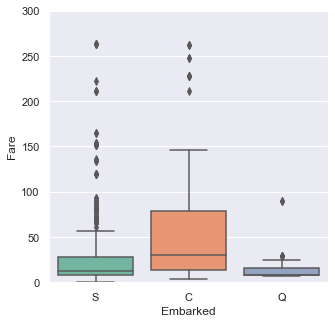

In [30]:
sns.set()
sns.despine(left=True)
fig, ax = plt.subplots(figsize=(5,5))
plt.ylim(0, 300)
sns.boxplot(x=training3['Embarked'], y=training3['Fare'], palette = "Set2")

With a fare of 80, we can reasonably guess that both passengers with missing embarkment locations embarked from "c."

In [31]:
training3['Embarked'].fillna('C', inplace=True)

### Conclusions from Analyzing Variables

*We have gone through and thoroughly understood the function of all these variables. There is still some work to be done, including the filling of the missing cases of the Age variable or simply bucketing continuous variables. Further decisions will be made once we can evaluate some models and I can determine how it can be improved.*

## ***Graphing Relationships***

*Using Matlib and the Seaborn Package, we can effectively visualize the data, and see any outstanding trends.*

In [32]:
sns.set()

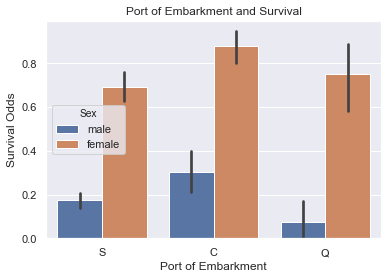

In [33]:
fig = sns.barplot(x="Embarked", y="Survived", hue="Sex", data=training3)
fig.set(xlabel='Port of Embarkment', ylabel='Survival Odds', title='Port of Embarkment and Survival')
plt.show()

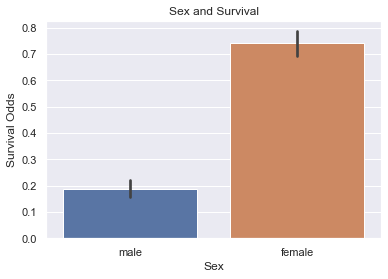

In [34]:
fig = sns.barplot(x="Sex", y="Survived", data=training3)
fig.set(xlabel='Sex', ylabel='Survival Odds', title='Sex and Survival')
plt.show()

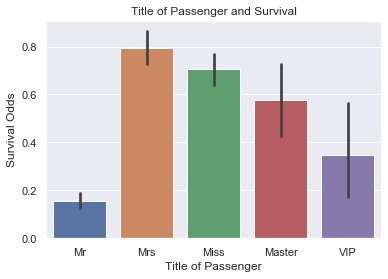

In [35]:
fig = sns.barplot(x="Title", y="Survived", data=training3)
fig.set(xlabel='Title of Passenger', ylabel='Survival Odds', title='Title of Passenger and Survival')
plt.show()

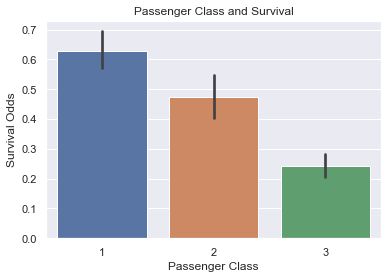

In [36]:
fig = sns.barplot(x="Pclass", y="Survived", data=training3)
fig.set(xlabel='Passenger Class', ylabel='Survival Odds', title='Passenger Class and Survival')
plt.show()

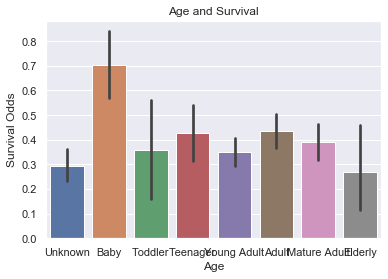

In [37]:
fig = sns.barplot(x ="AgeBin", y="Survived", data=training3)
fig.set(xlabel='Age', ylabel='Survival Odds', title='Age and Survival')
plt.show()

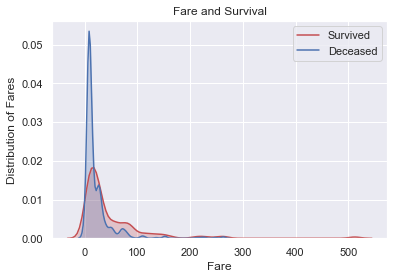

In [38]:
fig = sns.kdeplot(training3[(training3['Survived'] == 1)]['Fare'], shade = True, color = "r")
fig = sns.kdeplot(training3[(training3['Survived'] == 0)]['Fare'], shade = True, color = "b")
fig.set(xlabel='Fare', ylabel='Distribution of Fares', title='Fare and Survival')
plt.legend(loc='upper right', labels=['Survived', 'Deceased'])
plt.show()

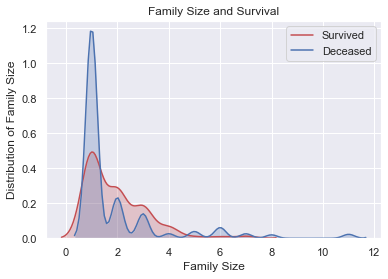

In [39]:
fig = sns.kdeplot(training3[(training3['Survived'] == 1)]['GroupSize'], shade = True, color = "r")
fig = sns.kdeplot(training3[(training3['Survived'] == 0)]['GroupSize'], shade = True, color = "b")
fig.set(xlabel='Family Size', ylabel='Distribution of Family Size', title='Family Size and Survival')
plt.legend(loc='upper right', labels=['Survived', 'Deceased'])
plt.show()

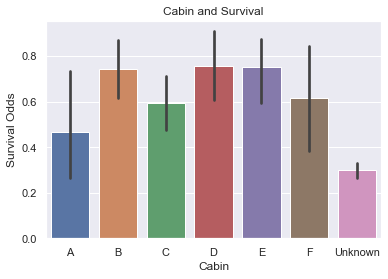

In [40]:
fig = sns.barplot(x ="Cabin", y="Survived", data=training3, order=["A", "B", "C", "D", "E", "F", "Unknown"])
fig.set(xlabel='Cabin', ylabel='Survival Odds', title='Cabin and Survival')
plt.show()